64
192
768
2048


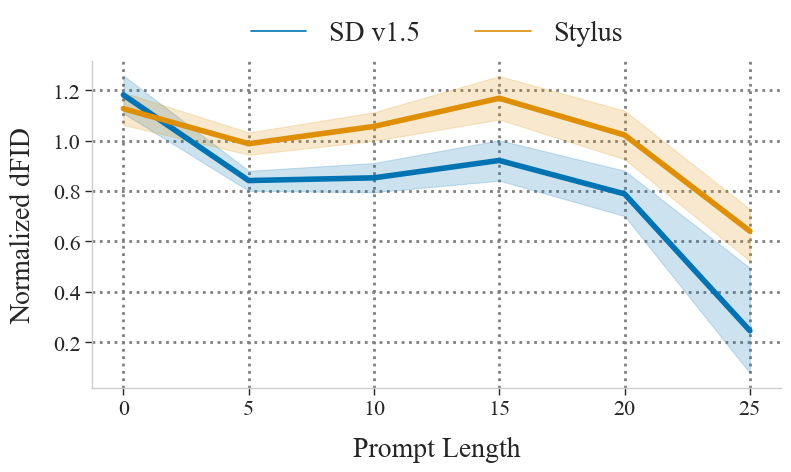

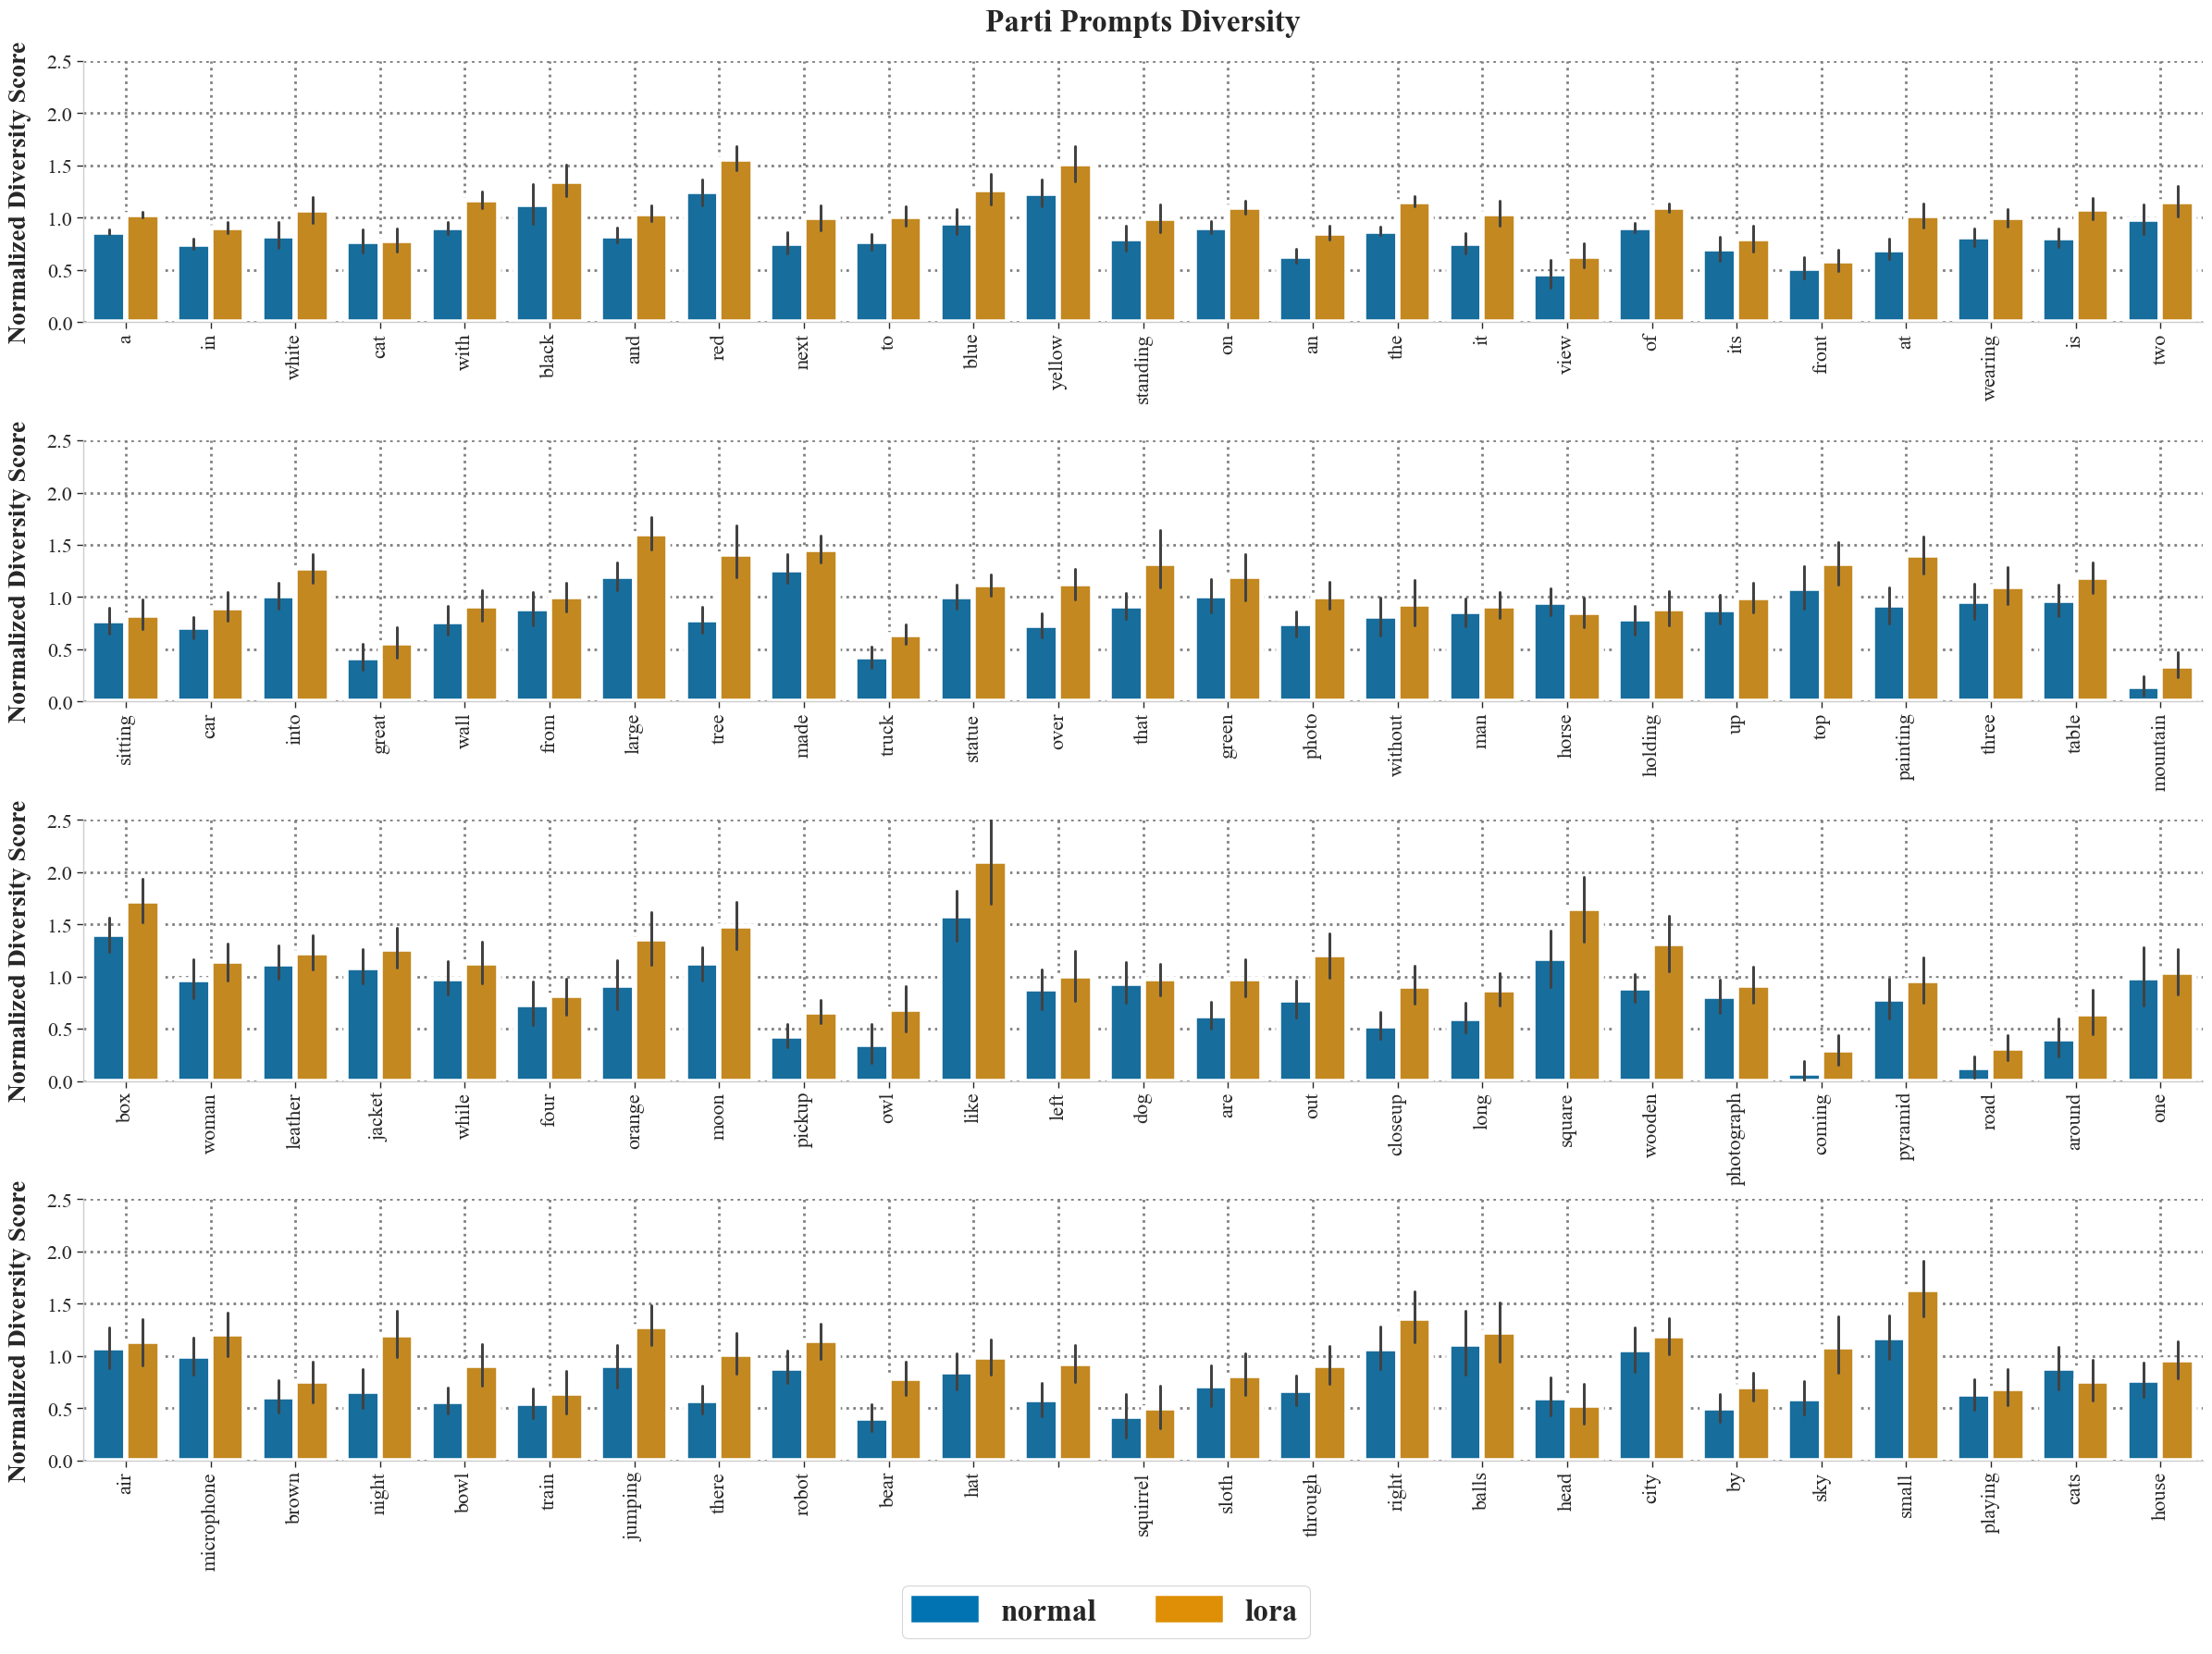

In [2]:
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

dataframe = pd.read_csv('data/eval_diversity.csv')

sns.set(style="whitegrid")
sns.set_context("paper")
sns.set_palette("colorblind")

word_frequency = defaultdict(int)

for num_features in dataframe['num_features'].unique():
    print(num_features)

    data = dataframe.loc[dataframe['num_features'] == num_features]

    mean_value = data['diversity_score'].mean()
    standard_dev_value = data['diversity_score'].std()

    normalized_diversity_score = (
        data['diversity_score'] - mean_value
    ) / standard_dev_value

    dataframe.loc[
        dataframe['num_features'] == num_features,
        'normalized_diversity_score'
    ] = 1 + normalized_diversity_score

def calculate_prompt_len(x):

    words = x["prompt"].split("_")

    for word in words: word_frequency[word.lower()] += 1

    return (len(words) // 5) * 5

dataframe["prompt_len"] = dataframe.apply(
    calculate_prompt_len, axis=1)

color_palette = sns.color_palette("colorblind")

matplotlib.rc('font', serif='cm10')
matplotlib.rc('mathtext', fontset='cm')

plt.rcParams['text.usetex'] = False
plt.rcParams["font.family"] = "Times New Roman"

fig, axis = plt.subplots(1, 1, figsize=(8, 6))

axis = sns.lineplot(
    data=dataframe,
    x='prompt_len',
    y='normalized_diversity_score',
    hue="method",
    errorbar=("ci", 95),
    ax=axis,
    linewidth=4,
)

handles, labels = axis.get_legend_handles_labels()
# axis.legend([],[], frameon=False)

axis.spines['right'].set_visible(False)
axis.spines['top'].set_visible(False)

axis.xaxis.set_ticks_position('bottom')
axis.yaxis.set_ticks_position('left')

axis.yaxis.set_tick_params(labelsize=16)
axis.xaxis.set_tick_params(labelsize=16)

axis.grid(
    color='grey',
    linestyle='dotted',
    linewidth=2,
)

axis.set_xlabel(
    "Prompt Length",
    fontsize=20,
    labelpad=12,
)

axis.legend(loc='upper center', bbox_to_anchor=(0.5, 1.20), ncol=3, frameon=False, fontsize=20)
# change legend labels
for t, l in zip(axis.get_legend().texts, ["SD v1.5", "Stylus"]): t.set_text(l)

axis.set_ylabel(
    "Normalized dFID",
    fontsize=20,
    labelpad=12,
)

plt.tight_layout()
fig.subplots_adjust(
    bottom=0.3,
)

plt.savefig('figures/diversity_len.pdf', format="pdf", dpi=300, bbox_inches="tight")

keywords_dataframe_records = []

def add_to_keywords(x):

    words = x["prompt"].split("_")

    for word in words:
        
        keywords_dataframe_records.append({
            "keyword": word.lower(),
            "keyword_frequency": word_frequency[word.lower()],
            "prompt_len": (len(words) // 5) * 5,
            "normalized_diversity_score": 
                x["normalized_diversity_score"],
            "method": x["method"],
            "num_features": x["num_features"],
            "num_samples": x["num_samples"],
        })

dataframe.apply(add_to_keywords, axis=1)

keywords_dataframe = pd.DataFrame.from_records(
    keywords_dataframe_records)

most_frequent_keywords = sorted(
    word_frequency.items(),
    key=lambda x: x[1],
    reverse=True)[:100]

fig, axes = plt.subplots(4, 1, figsize=(24, 18))

for i in range(4):

    active_keywords_dataframe = keywords_dataframe.loc[
        keywords_dataframe["keyword"].isin(
            [x[0] for x in most_frequent_keywords[i * 25:(i + 1) * 25]]
        )
    ]

    axis = sns.barplot(
        data=active_keywords_dataframe,
        x='keyword',
        y='normalized_diversity_score',
        hue="method",
        errorbar=("ci", 95),
        ax=axes[i],
        linewidth=4,
    )

    if i == 0: handles, labels = axis.get_legend_handles_labels()
    axis.legend([],[], frameon=False)

    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)

    axis.xaxis.set_ticks_position('bottom')
    axis.yaxis.set_ticks_position('left')

    axis.yaxis.set_tick_params(labelsize=16)
    axis.xaxis.set_tick_params(labelsize=16, rotation=90)

    axis.grid(
        color='grey',
        linestyle='dotted',
        linewidth=2,
    )

    if i == 0:

        axis.set_title(
            "Parti Prompts Diversity",
            fontsize=24,
            fontweight='bold',
            pad=24,
        )

    axis.set_xlabel(
        "",
    )

    axis.set_ylabel(
        "Normalized Diversity Score",
        fontsize=20,
        labelpad=12,
        fontdict=dict(weight='bold'),
    )

    axis.set_ylim(0.0, 2.5)

legend = fig.legend(
    handles, labels,
    loc="lower center",
    prop={'size': 24, 'weight': 'bold'}, 
    ncol=len(labels),
)

for i, legend_object in enumerate(legend.legend_handles):
    legend_object.set_linewidth(4.0)
    legend_object.set_color(color_palette[i])

plt.tight_layout()
fig.subplots_adjust(
    bottom=0.12,
)
